In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import control
from scipy.optimize import curve_fit

# 1ª Sessão

### Secção Biquadrática de Kerwin, Huelsman e Newman (KHN)

Definição dos parâmetros dos componentes usados:

In [4]:
k   = 1e3
M   = 1e6
n   = 1e-9

C1  = 4.7*n
C2  = 4.7*n

P1  = 100*k
P2  = 10*k

R1  = 51*k
R2  = 100*k
R3  = 10*k
R4  = 10*k
R5  = 100*k
R6  = 10*k
R7  = 1*M
R8  = 100*k
R9  = 51*k
R10 = 100*k
R11 = 10

In [5]:
def convert_to_dB(w):
    return [20*(np.log10(abs(i))) for i in w]

Definição do Ganho, frequência proibida e fator de qualidade: 

In [6]:
K  = (P2/(R3 + P2))*(1 + R5/R2)

wp = np.sqrt(R5/(R2*C1*C2*R6*R11))

Q  = np.sqrt(R5/(R2*C1*C2*R6*R11))/((R3/((R3+R3)*C1*R6))*(1+R5/R2))

In [7]:
K = 1
Q = 1
wp= 21276.6

Funções de Transferência

In [8]:
def T1(s):
    return (K*s**2)/(s**2 + s * wp/Q + wp**2)

def T2(s):
    return (K*s*wp)/(s**2 + s * wp/Q + wp**2)

def T3(s):
    return (K*wp**2)/(s**2 + s * wp/Q + wp**2)

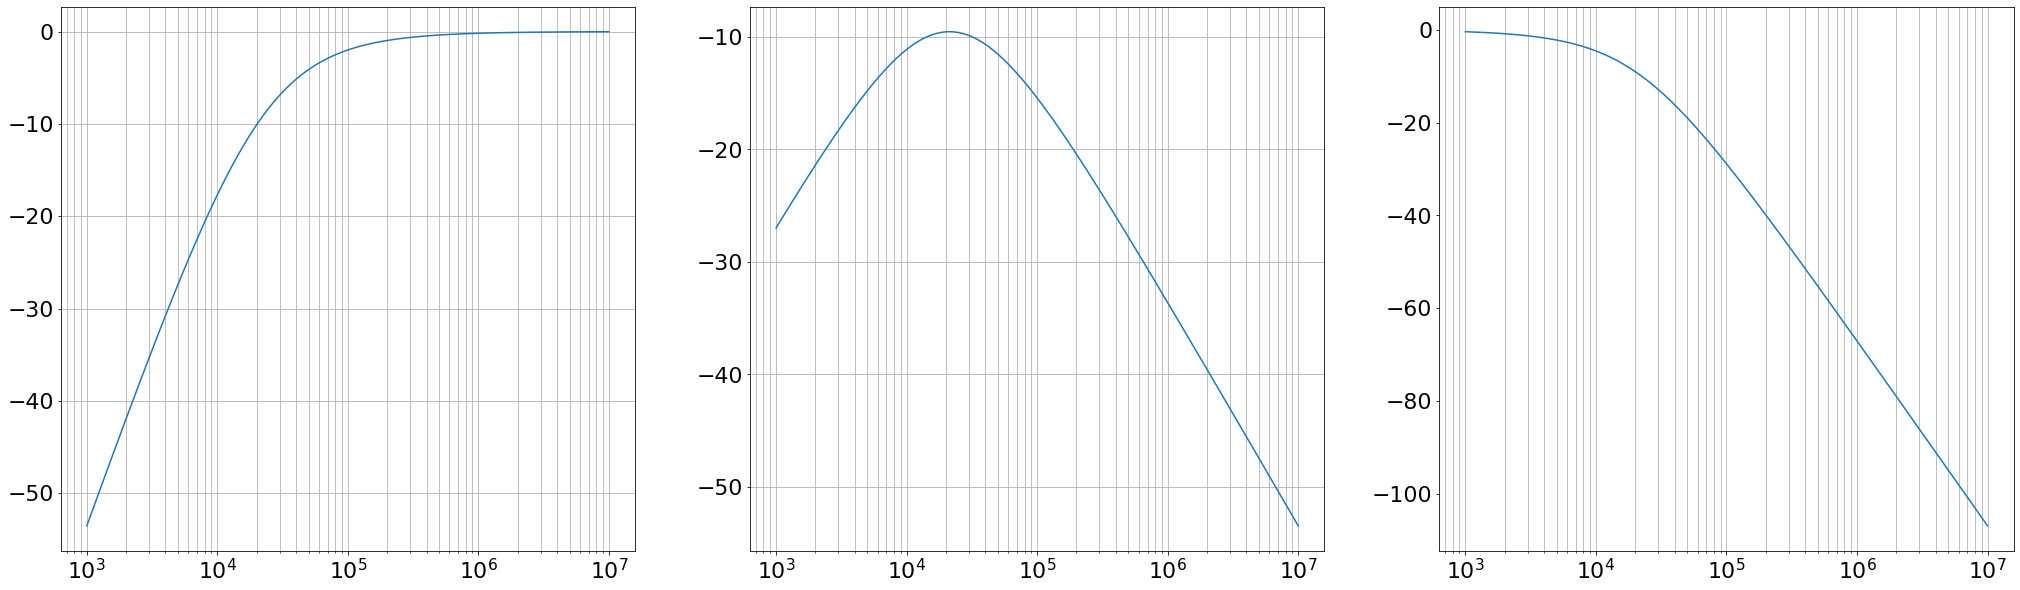

In [9]:
plt.rcParams.update({'font.size': 22})

s = np.linspace(1e3, 1e7, 1e5)
fig = plt.figure()
fig.set_size_inches(35, 10)


ax1 = fig.add_subplot(1, 3, 1)

ax1.set_xscale('log')
ax1.grid(True, which="both")
ax1.plot(s, convert_to_dB(T1(s)))


ax2 = fig.add_subplot(1, 3, 2)

ax2.set_xscale('log')
ax2.grid(True, which="both")
ax2.plot(s, convert_to_dB(T2(s)))


ax3 = fig.add_subplot(1, 3, 3)

ax3.set_xscale('log')
ax3.grid(True, which="both", axis='x')
ax3.plot(s, convert_to_dB(T3(s)))

## Dados Experimentais

In [10]:
def fit_func(x, p0, p1, p2, p3):
    return p0*np.sin(p1*x + p2) + p3

CORRER AS PRÓXIMAS 3 CÉLULAS ANTES Do PLOT DE CADA GRÁFICO.

NÃO ESQUECER DE MUDAR A VARIÁVEL 'ch_out' PARA CADA CASO

In [11]:
path = '/Users/thomasgaehtgens/Downloads/DADOS GRUPO 7 6a.xlsx'

db     = pd.ExcelFile(path)
sheets = dict() #DICIONÁRIO COM AS FOLHAS

for freq in db.sheet_names:
    data = db.parse(freq)[['Time (Secs)', 'CHAN1', 'CHAN2', 'CHAN3', 'CHAN4']]
    sheets[freq] = data
    
sheet_names = [freq[:-2] for freq in db.sheet_names]

freqs = list() #LISTA COM OS VALORES DE FREQUÊNCIA
for freq in sheet_names:
    if freq[-1] == 'K':
        freqs.append(float(freq[:-1])*1e3)
    else:
        freqs.append(float(freq))

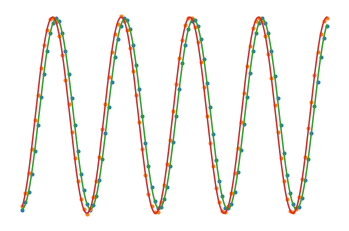

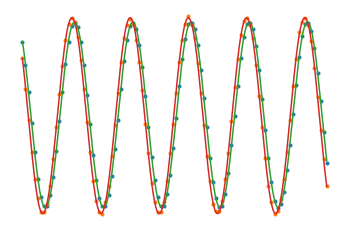

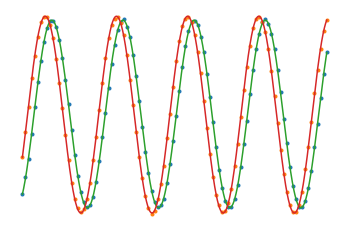

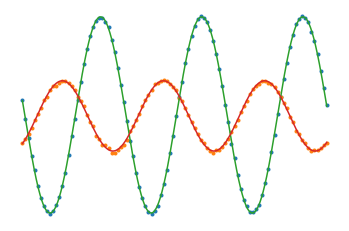

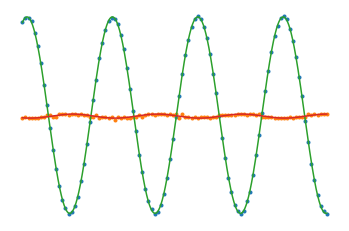

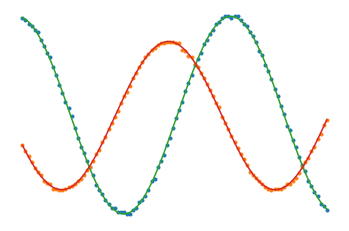

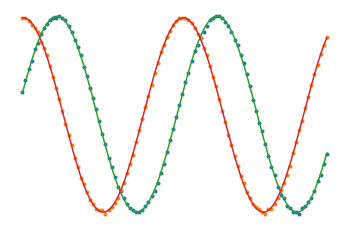

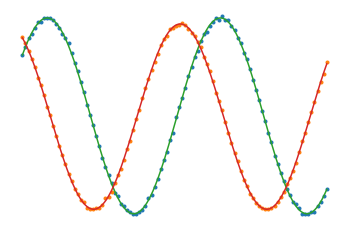

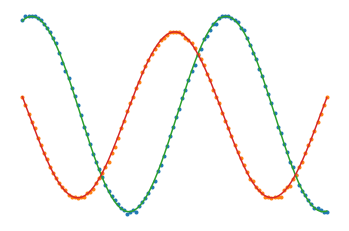

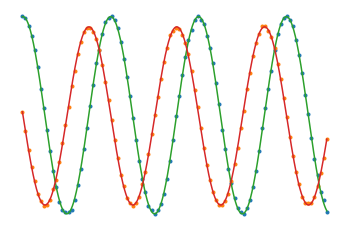

In [12]:
ch_in  = 'CHAN1'
ch_out = 'CHAN2'

AMPS   = list()
i=0
for freq in db.sheet_names:
    fig = plt.figure()
    plt.axis(False)
    
    data = sheets[freq] 
    
    popti, pcov = curve_fit(fit_func, data['Time (Secs)'], data[ch_in] , p0=[0.5, 6*freqs[i], 0, 0])
    popto, pcov = curve_fit(fit_func, data['Time (Secs)'], data[ch_out], p0=[0.5, 6*freqs[i], 0, 0])

    plt.plot(data['Time (Secs)'], data[ch_in] , '.', label=ch_in )
    plt.plot(data['Time (Secs)'], data[ch_out], '.', label=ch_out)
    
    db_time = list(data['Time (Secs)'])
    time = np.linspace(db_time[0], db_time[-1], 1000)

    plt.plot(time, fit_func(time, popti[0], popti[1], popti[2], popti[3]))
    plt.plot(time, fit_func(time, popto[0], popto[1], popto[2], popto[3]))
    
    AMPS.append(abs(popti[0])/abs(popto[0]))
    
    i += 1

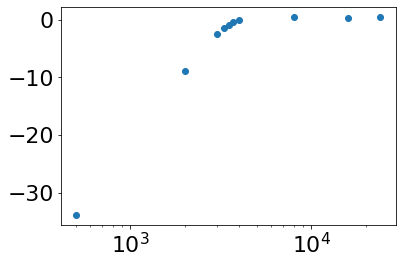

In [13]:
AMPS = [y for x,y in sorted(zip(freqs,AMPS))]
freqs.sort()

fig = plt.figure()
ax  = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.plot(freqs, [-20*np.log10(AMP) for AMP in AMPS], 'o')

## Plots

Usando a biblioteca fixe

### T1(s)

In [449]:
G = control.tf([K, 0, 0],[1,wp/Q, wp**2])
print(G)


             s^2
-----------------------------
s^2 + 2.128e+04 s + 4.527e+08



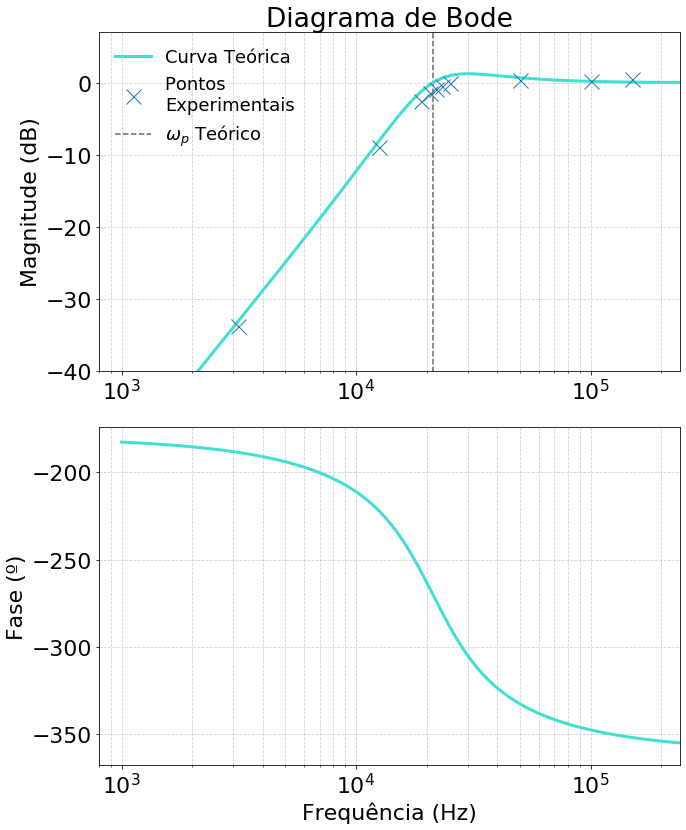

In [451]:
mag,phase,omega = control.bode(G, dB=True, plot=False)

fig = plt.figure()
fig.set_size_inches(10, 12)

ax1 = fig.add_subplot(2, 1, 1)
plt.title('Diagrama de Bode')

ax2 = fig.add_subplot(2, 1, 2)
plt.xlabel(r'Frequência (Hz)')

#RESULTADOS TEÓRICOS
ax1.plot(omega, 20*np.log10(mag) , lw=3, color='turquoise', label='Curva Teórica')
ax2.plot(omega, phase*180/(np.pi), lw=3, color='turquoise')
#DADOS EXPERIMENTAIS
ax1.plot([freq*2*np.pi for freq in freqs], [-20*np.log10(AMP) for AMP in AMPS], 'x', label='Pontos \nExperimentais', markersize=15)

ax1.vlines(wp, -70, 7, lw=1.5, linestyle='--', label=r'$\omega_p$ Teórico', alpha=0.6)
ax1.set_ylim(-40, 7)
ax1.set_xlim(8*1e2, 2.4*1e5)

#ax2.vlines(wp, -180, 2, lw=1.5, linestyle='--', zorder = 10)
#ax2.set_ylim(-180, 2)
ax2.set_xlim(8*1e2, 2.4*1e5)

ax1.set_ylabel('Magnitude (dB)')
ax2.set_ylabel('Fase (º)')

ax1.legend(frameon=False, fontsize = 18)

ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.grid(True, which="both", linestyle='--', alpha=0.6)
ax2.grid(True, which="both", linestyle='--', alpha=0.6)

fig.tight_layout()
fig.savefig('T1.pdf')

## T2(s)

In [425]:
G = control.tf([K*wp, 0],[1,wp/Q, wp**2])
print(G)


         2.128e+04 s
-----------------------------
s^2 + 2.128e+04 s + 4.527e+08



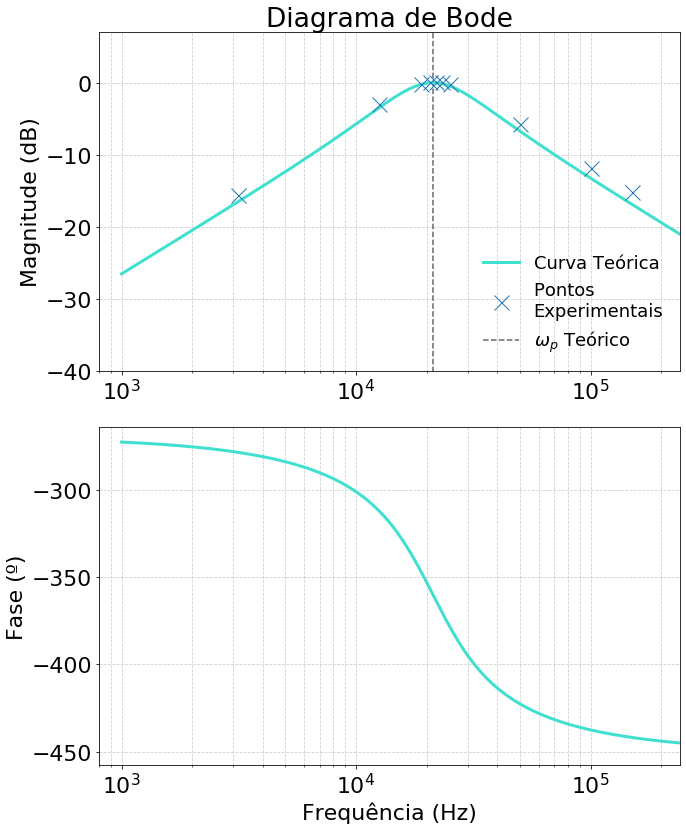

In [435]:
mag,phase,omega = control.bode(G, dB=True, plot=False)

fig = plt.figure()
fig.set_size_inches(10, 12)

ax1 = fig.add_subplot(2, 1, 1)
plt.title('Diagrama de Bode')

ax2 = fig.add_subplot(2, 1, 2)
plt.xlabel(r'Frequência (Hz)')

#RESULTADOS TEÓRICOS
ax1.plot(omega, 20*np.log10(mag) , lw=3, color='turquoise', label='Curva Teórica')
ax2.plot(omega, phase*180/(np.pi), lw=3, color='turquoise')
#DADOS EXPERIMENTAIS
ax1.plot([freq*2*np.pi for freq in freqs], [-20*np.log10(AMP) for AMP in AMPS], 'x', label='Pontos \nExperimentais', markersize=15)

ax1.vlines(wp, -70, 7, lw=1.5, linestyle='--', label=r'$\omega_p$ Teórico', alpha=0.6)
ax1.set_ylim(-40, 7)
ax1.set_xlim(8*1e2, 2.4*1e5)

#ax2.vlines(wp, -180, 2, lw=1.5, linestyle='--', zorder = 10)
#ax2.set_ylim(-180, 2)
ax2.set_xlim(8*1e2, 2.4*1e5)

ax1.set_ylabel('Magnitude (dB)')
ax2.set_ylabel('Fase (º)')

ax1.legend(frameon=False, fontsize = 18)

ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.grid(True, which="both", linestyle='--', alpha=0.6)
ax2.grid(True, which="both", linestyle='--', alpha=0.6)

fig.tight_layout()
fig.savefig('T2.pdf')

## T3(s)

In [353]:
G = control.tf([K*wp**2],[1,wp/Q, wp**2])
print(G)


          4.527e+08
-----------------------------
s^2 + 2.128e+04 s + 4.527e+08



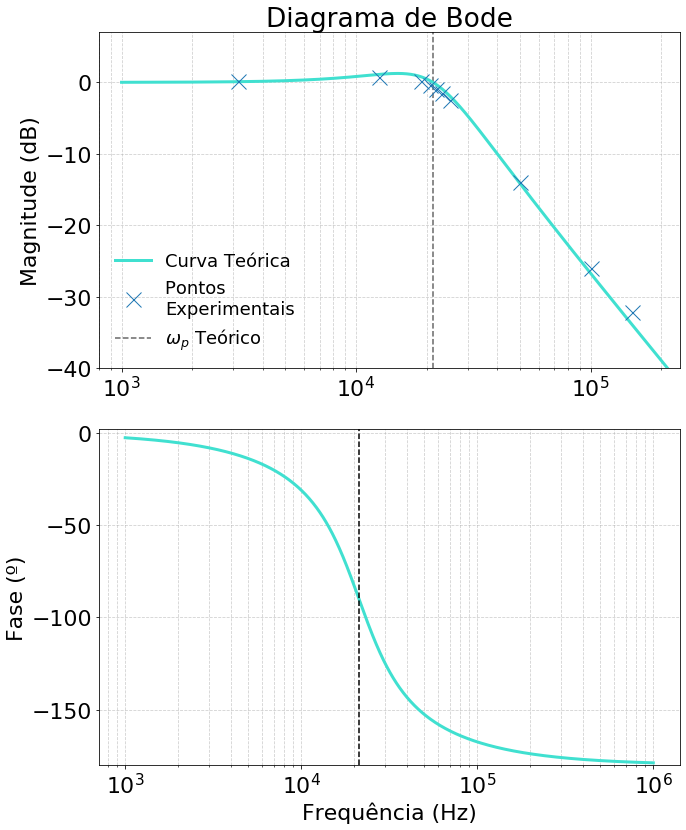

In [403]:
mag,phase,omega = control.bode(G, dB=True, plot=False)

fig = plt.figure()
fig.set_size_inches(10, 12)

ax1 = fig.add_subplot(2, 1, 1)
plt.title('Diagrama de Bode')

ax2 = fig.add_subplot(2, 1, 2)
plt.xlabel(r'Frequência (Hz)')

#RESULTADOS TEÓRICOS
ax1.plot(omega, 20*np.log10(mag) , lw=3, color='turquoise', label='Curva Teórica')
ax2.plot(omega, phase*180/(np.pi), lw=3, color='turquoise')
#DADOS EXPERIMENTAIS
ax1.plot([freq*2*np.pi for freq in freqs], [-20*np.log10(AMP) for AMP in AMPS], 'x', label='Pontos \nExperimentais', markersize=15)
ax1.vlines(wp, -70, 7, lw=1.5, linestyle='--', label=r'$\omega_p$ Teórico', alpha=0.6)
ax1.set_ylim(-40, 7)
ax1.set_xlim(8*1e2, 2.4*1e5)

ax2.vlines(wp, -180, 2, lw=1.5, linestyle='--', zorder = 10)
ax2.set_ylim(-180, 2)
ax1.set_xlim(8*1e2, 2.4*1e5)

ax1.set_ylabel('Magnitude (dB)')
ax2.set_ylabel('Fase (º)')

ax1.legend(frameon=False, fontsize = 18)

ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.grid(True, which="both", linestyle='--', alpha=0.6)
ax2.grid(True, which="both", linestyle='--', alpha=0.6)

fig.tight_layout()
fig.savefig('T3.pdf')

# 2ª Sessão

## Dados Experimentais

In [30]:
paths = ['/Users/thomasgaehtgens/Downloads/Dados 2o LAB/GRUPO 7 2a SESSAO R=0.5KOhm.xlsx',
         '/Users/thomasgaehtgens/Downloads/Dados 2o LAB/GRUPO 7 2a SESSAO R=1KOhm.xlsx',
         '/Users/thomasgaehtgens/Downloads/Dados 2o LAB/GRUPO 7 2a SESSAO R=5KOhm.xlsx',
         '/Users/thomasgaehtgens/Downloads/Dados 2o LAB/GRUPO 7 2a SESSAO R=10KOhm.xlsx']

In [49]:
path  = paths[-1]

db     = pd.ExcelFile(path)
sheets = dict() #DICIONÁRIO COM AS FOLHAS

for freq in db.sheet_names:
    data = db.parse(freq)[['Time (Secs)', 'CHAN1', 'CHAN2', 'CHAN3', 'CHAN4']]
    sheets[freq] = data
    
sheet_names = [freq[:-2] for freq in db.sheet_names]

freqs = list() #LISTA COM OS VALORES DE FREQUÊNCIA
for freq in sheet_names:
    if freq[-1] == 'K':
        freqs.append(float(freq[:-1])*1e3)
    else:
        freqs.append(float(freq))

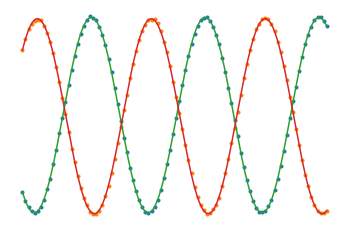

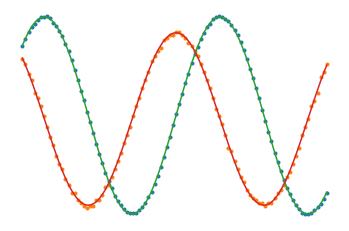

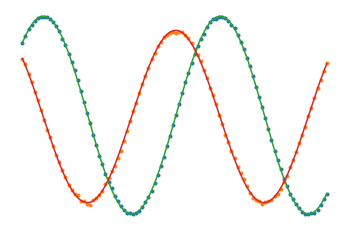

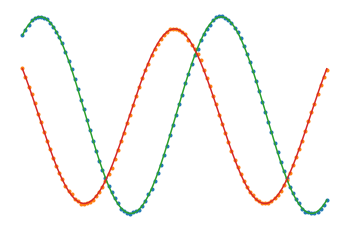

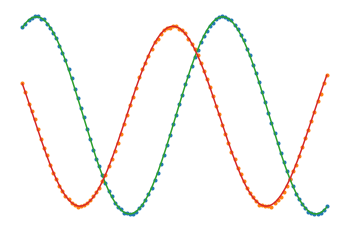

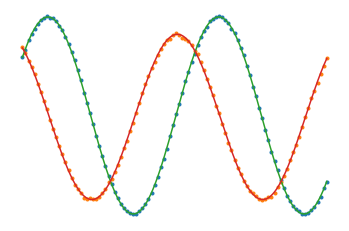

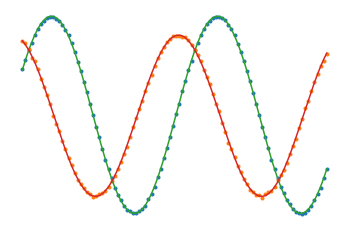

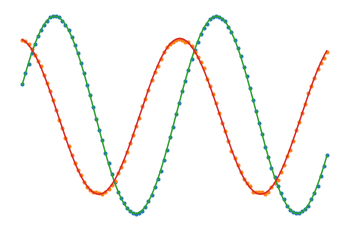

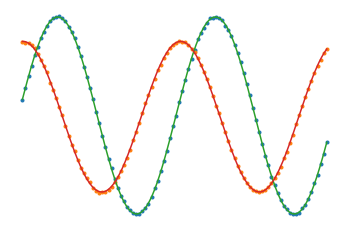

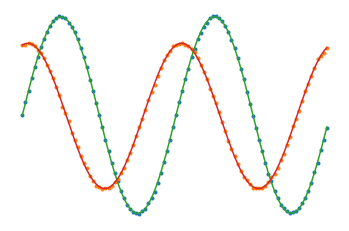

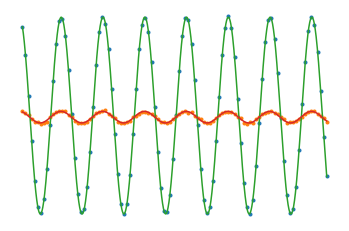

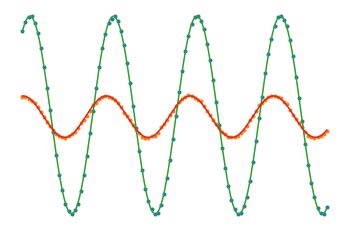

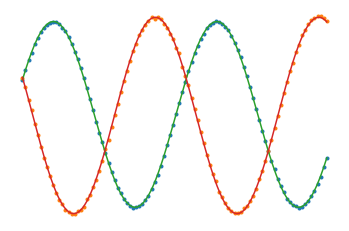

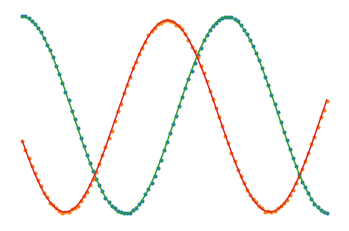

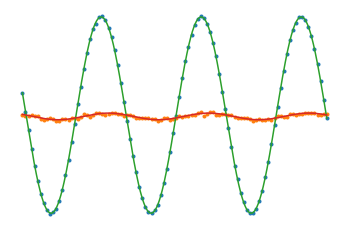

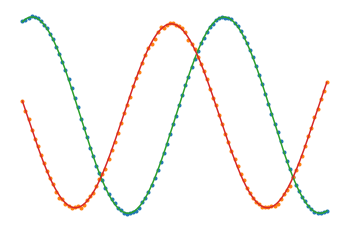

In [50]:
ch_in  = 'CHAN1'
ch_out = 'CHAN4'

AMPS   = list()
i=0
for freq in db.sheet_names:
    fig = plt.figure()
    plt.axis(False)
    
    data = sheets[freq] 
    
    popti, pcov = curve_fit(fit_func, data['Time (Secs)'], data[ch_in] , p0=[0.5, 6*freqs[i], 0, 0])
    popto, pcov = curve_fit(fit_func, data['Time (Secs)'], data[ch_out], p0=[0.5, 6*freqs[i], 0, 0])

    plt.plot(data['Time (Secs)'], data[ch_in] , '.', label=ch_in )
    plt.plot(data['Time (Secs)'], data[ch_out], '.', label=ch_out)
    
    db_time = list(data['Time (Secs)'])
    time = np.linspace(db_time[0], db_time[-1], 1000)

    plt.plot(time, fit_func(time, popti[0], popti[1], popti[2], popti[3]))
    plt.plot(time, fit_func(time, popto[0], popto[1], popto[2], popto[3]))
    
    AMPS.append(abs(popti[0])/abs(popto[0]))
    
    i += 1

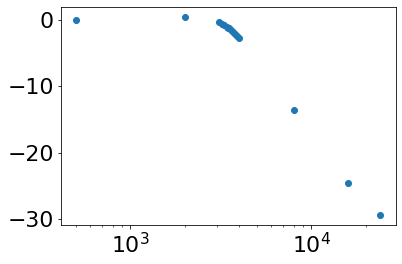

In [51]:
AMPS = [y for x,y in sorted(zip(freqs,AMPS))]
freqs.sort()

fig = plt.figure()
ax  = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.plot(freqs, [-20*np.log10(AMP) for AMP in AMPS], 'o')

## T1(s)

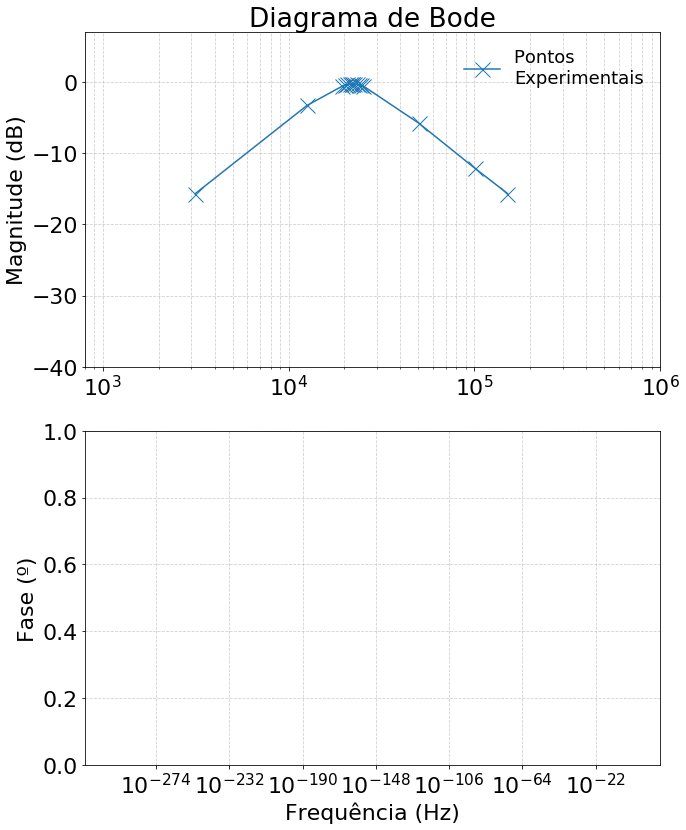

In [40]:
#mag,phase,omega = control.bode(G, dB=True, plot=False)

fig = plt.figure()
fig.set_size_inches(10, 12)

ax1 = fig.add_subplot(2, 1, 1)
plt.title('Diagrama de Bode')

ax2 = fig.add_subplot(2, 1, 2)
plt.xlabel(r'Frequência (Hz)')

#RESULTADOS TEÓRICOS
#ax1.plot(omega, 20*np.log10(mag) , lw=3, color='turquoise', label='Curva Teórica')
#ax2.plot(omega, phase*180/(np.pi), lw=3, color='turquoise')
#DADOS EXPERIMENTAIS
ax1.plot([freq*2*np.pi for freq in freqs], [-20*np.log10(AMP) for AMP in AMPS], marker='x', label='Pontos \nExperimentais', markersize=15)

#ax1.vlines(wp, -70, 7, lw=1.5, linestyle='--', label=r'$\omega_p$ Teórico', alpha=0.6)
ax1.set_ylim(-40, 7)
ax1.set_xlim(8*1e2, 1e6)

#ax2.vlines(wp, -180, 2, lw=1.5, linestyle='--', zorder = 10)
#ax2.set_ylim(-180, 2)
#ax2.set_xlim(8*1e2, 1e6)

ax1.set_ylabel('Magnitude (dB)')
ax2.set_ylabel('Fase (º)')

ax1.legend(frameon=False, fontsize = 18)

ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.grid(True, which="both", linestyle='--', alpha=0.6)
ax2.grid(True, which="both", linestyle='--', alpha=0.6)

fig.tight_layout()
fig.savefig('T1_2.pdf')

## T2(s)

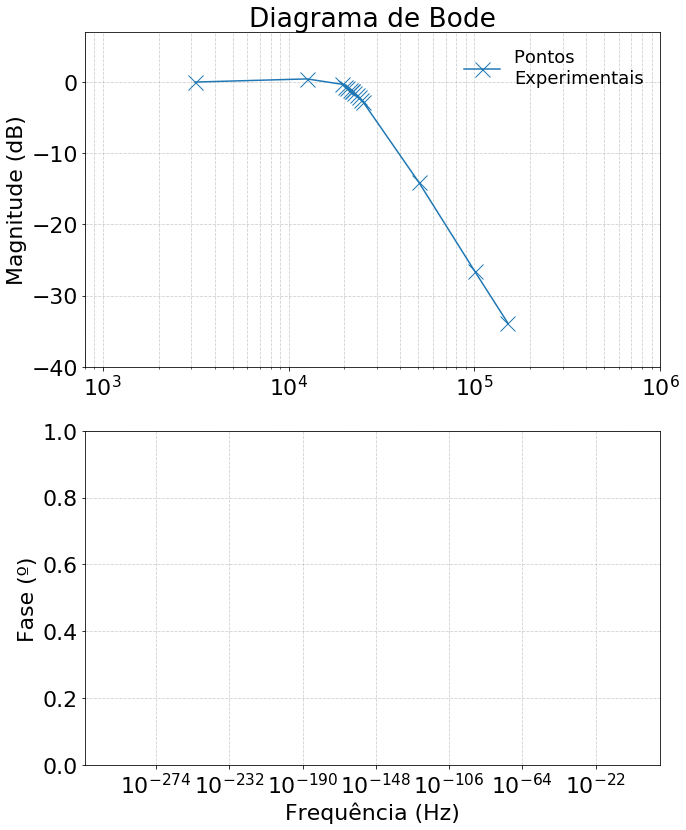

In [48]:
#mag,phase,omega = control.bode(G, dB=True, plot=False)

fig = plt.figure()
fig.set_size_inches(10, 12)

ax1 = fig.add_subplot(2, 1, 1)
plt.title('Diagrama de Bode')

ax2 = fig.add_subplot(2, 1, 2)
plt.xlabel(r'Frequência (Hz)')

#RESULTADOS TEÓRICOS
#ax1.plot(omega, 20*np.log10(mag) , lw=3, color='turquoise', label='Curva Teórica')
#ax2.plot(omega, phase*180/(np.pi), lw=3, color='turquoise')
#DADOS EXPERIMENTAIS
ax1.plot([freq*2*np.pi for freq in freqs], [-20*np.log10(AMP) for AMP in AMPS], marker='x', label='Pontos \nExperimentais', markersize=15)

#ax1.vlines(wp, -70, 7, lw=1.5, linestyle='--', label=r'$\omega_p$ Teórico', alpha=0.6)
ax1.set_ylim(-40, 7)
ax1.set_xlim(8*1e2, 1e6)

#ax2.vlines(wp, -180, 2, lw=1.5, linestyle='--', zorder = 10)
#ax2.set_ylim(-180, 2)
#ax2.set_xlim(8*1e2, 1e6)

ax1.set_ylabel('Magnitude (dB)')
ax2.set_ylabel('Fase (º)')

ax1.legend(frameon=False, fontsize = 18)

ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.grid(True, which="both", linestyle='--', alpha=0.6)
ax2.grid(True, which="both", linestyle='--', alpha=0.6)

fig.tight_layout()
fig.savefig('T2_2.pdf')

## T3(s)

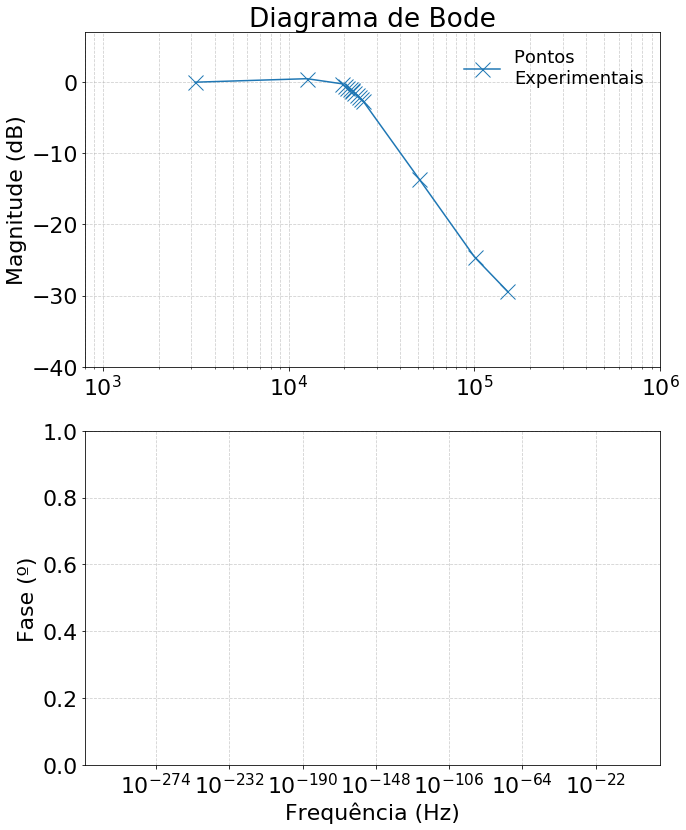

In [52]:
#mag,phase,omega = control.bode(G, dB=True, plot=False)

fig = plt.figure()
fig.set_size_inches(10, 12)

ax1 = fig.add_subplot(2, 1, 1)
plt.title('Diagrama de Bode')

ax2 = fig.add_subplot(2, 1, 2)
plt.xlabel(r'Frequência (Hz)')

#RESULTADOS TEÓRICOS
#ax1.plot(omega, 20*np.log10(mag) , lw=3, color='turquoise', label='Curva Teórica')
#ax2.plot(omega, phase*180/(np.pi), lw=3, color='turquoise')
#DADOS EXPERIMENTAIS
ax1.plot([freq*2*np.pi for freq in freqs], [-20*np.log10(AMP) for AMP in AMPS], marker='x', label='Pontos \nExperimentais', markersize=15)

#ax1.vlines(wp, -70, 7, lw=1.5, linestyle='--', label=r'$\omega_p$ Teórico', alpha=0.6)
ax1.set_ylim(-40, 7)
ax1.set_xlim(8*1e2, 1e6)

#ax2.vlines(wp, -180, 2, lw=1.5, linestyle='--', zorder = 10)
#ax2.set_ylim(-180, 2)
#ax2.set_xlim(8*1e2, 1e6)

ax1.set_ylabel('Magnitude (dB)')
ax2.set_ylabel('Fase (º)')

ax1.legend(frameon=False, fontsize = 18)

ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.grid(True, which="both", linestyle='--', alpha=0.6)
ax2.grid(True, which="both", linestyle='--', alpha=0.6)

fig.tight_layout()
fig.savefig('T3_2.pdf')